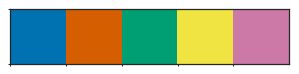

In [1]:
from collections import defaultdict
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_logo as logo

from pysam import FastaFile

sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

## Protein motif logos:

In [4]:
PROT_FASTA_FN = (
    '/home/matthew/Documents/genomes/tair10/fasta/tair10_pep.fa'
)

tyr_motifs = []
prot = FastaFile(PROT_FASTA_FN)
for seq_id in prot.references:
    seq = prot.fetch(seq_id)
    tyr_motifs += re.findall(r'.{4}PPPP.{4}', seq)

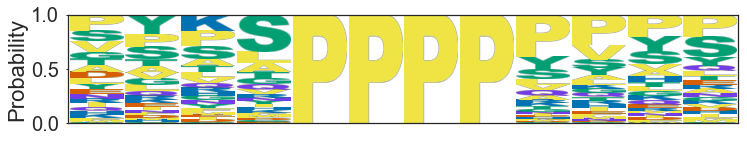

In [6]:
logo.draw_logo(tyr_motifs,
               alphabet='protein',
               cmap='aa_chemistry',
               y_format='probability')
plt.savefig('/home/matthew/matplotlib_logo/images/proline_motif.png')
plt.show()

## Splice junction logos:

In [2]:
GTF_FN = (
    '/home/matthew/Documents/genomes/tair10/gff/'
    'Araport11_GFF3_genes_transposons.201606.gtf'
)

FASTA_FN = (
    '/home/matthew/Documents/genomes/tair10/'
    'fasta/tair10_genome.fa'
)

n = 8

def exons_to_introns(exons):
    exons.sort(key=lambda x: x[0])
    introns = list(zip([x[1] for x in exons[:-1]],
                       [x[0] for x in exons[1:]]))
    return introns

def revcomp(seq):
    comp = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N': 'N'}
    return ''.join([comp[b] for b in seq.upper()][::-1])

transcript_exons = defaultdict(list)
transcript_strand = {}
with open(GTF_FN) as f:
    for record in f:
        *record, attr = record.strip(';\n').split('\t')
        attr = dict(kv.split(' ') for kv in attr.split('; '))
        transcript_exons[attr['transcript_id'].strip('"')].append(
            (int(record[3]) - 1, int(record[4])))
        transcript_strand[attr['transcript_id'].strip('"')] = (record[0], record[6])

transcript_introns = {
    transcript: exons_to_introns(exons)
    for transcript, exons in transcript_exons.items()
}

fasta = FastaFile(FASTA_FN)
intron_seq_data = []
for transcript, invs in transcript_introns.items():
    chrom, strand = transcript_strand[transcript]
    for i, j in invs:
        if strand == '-':
            i, j = j, i
        interval1 = fasta.fetch(chrom, i - n, i + n).upper()
        interval2 = fasta.fetch(chrom, j - n, j + n).upper()
        if strand == '-':
            interval1 = revcomp(interval1)
            interval2 = revcomp(interval2)
        intron_seq_data.append((transcript, strand, interval1, interval2))
intron_seq_data = pd.DataFrame(
    intron_seq_data, columns=['transcript_id', 'strand', 'donor', 'acceptor'])
intron_seq_data.head()

,transcript_id,strand,donor,acceptor
0,AT2G28780.1,-,TTAAAATAATATAACA,ATAAATGATAATATTT
1,AT2G28780.1,-,ATAAATGATAATATTT,GTATATAGCCAAGCAT
2,AT2G28780.1,-,TATAGCCAAGCATGAC,GTATATAGCCAAGCAT
3,AT2G28780.1,-,GTTACCAAGTAATATA,GTATATAGCCAAGCAT
4,AT2G28780.1,-,GTTACCAAGTAATATA,ATATATAGGTGAAACA


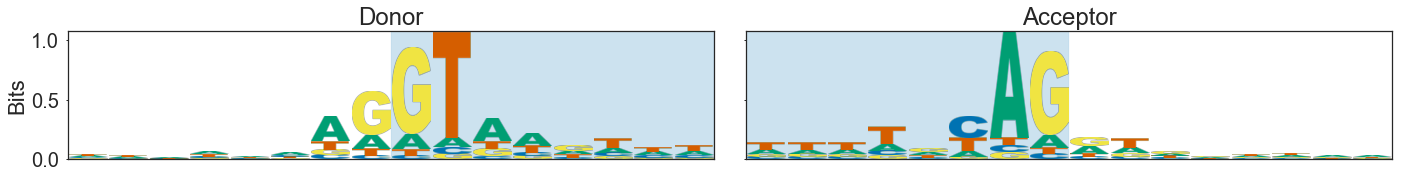

In [9]:
donors = intron_seq_data.donor.tolist()
acceptors = intron_seq_data.acceptor.tolist()
fig, axes = plt.subplots(figsize=(20, 3), ncols=2, sharey=True)
ax1, ax2 = axes.ravel()
logo.draw_logo(donors, ax=ax1)
logo.draw_logo(acceptors, ax=ax2)
ax1.set_title('Donor')
ax2.set_title('Acceptor')
ax2.set_ylabel('')
ax1.axvspan(8, 16, alpha=0.2, color=pal[0], zorder=0)
ax2.axvspan(0, 8, alpha=0.2, color=pal[0], zorder=0)
plt.tight_layout()
plt.savefig('/home/matthew/matplotlib_logo/images/splice_junc.png')
plt.show()